In [1]:
### Remember terminal 
#wsl 
#jupyter notebook

#when changing cpp reload kernal

In [1]:
!python3 -m pip install pybind11

In [2]:
!g++ -Wall fast_integrator.cpp -shared -O3 -march=native -ffast-math -lgsl -fPIC $(python3 -m pybind11 --includes) -o fast_integrator.so

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

import pickle
from pcygni_5 import PcygniCalculator
import implementation_copy as code



#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
c_cgs = csts.c.cgs.value
AA_in_cgs = units.AA.cgs.scale
c_cgs/1e10, AA_in_cgs

(2.99792458, 1.0000000000000002e-08)

In [3]:
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
import warnings
warnings.filterwarnings("ignore")

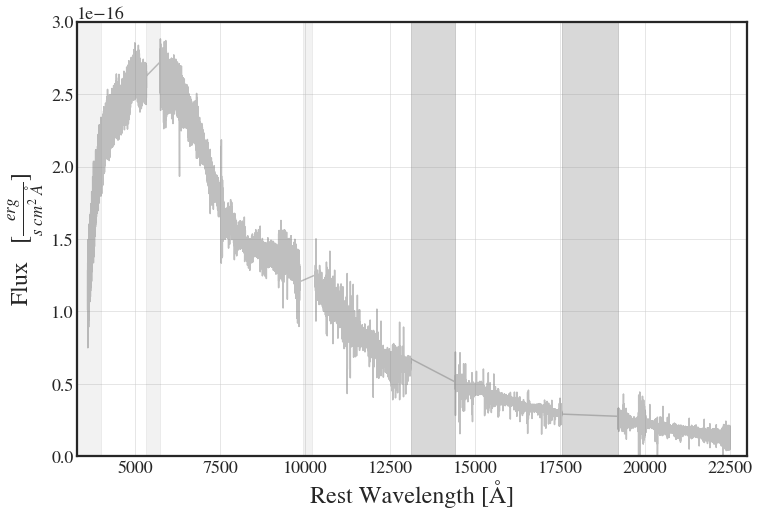

In [4]:
wl, flux, error = code.wl, code.flux, code.error

reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [5]:
beta1, doppler1 = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta1, doppler1)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #delta = (1-vphot**2)**(1/2) * 1/(1-vphot)
    #delta = (1-vphot**2)**(-1/2) * (1-vphot)
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

from scipy.interpolate import interp1d

In [6]:
import importlib
importlib.reload(code)

<module 'implementation_copy' from '/mnt/c/Users/asnep/Downloads/Kilonova/implementation_copy.py'>

#### Fit structure

In [11]:
residual_wrapper = lambda p, *args: code.residual(p.valuesdict(), *args)

p = lmfit.Parameters()
OB = 'OB1'
with open("./data/%s_conv_init.json"%OB, 'r') as infile:
    p.load(infile)

p['T'].value=5400/1.3;  
p['v_bb'].value=0.26  ; p['v_bb'].vary=True  
p['T_power'].value=0.36; p['T_power'].vary=False; 
#p['vphot'].value=0.28; 

    
code.new = False
start = time.time()
mi2 = lmfit.minimize(residual_wrapper, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 0.9559917569160461


In [13]:
mi2.params

name,value,initial value,min,max,vary
T,4122.00600,4153.846153846153,2500.00000,7500.00000,True
N,1.3857e-29,1.3e-29,-inf,inf,True
vphot,0.25839037,0.27,0.00000000,1.00000000,True
vmax,0.32856508,0.338,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,1.93210934,2.3,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.21553594,0.23,0.00000000,1.00000000,True
v_bb,0.30277204,0.26,0.00000000,1.00000000,True
T_power,0.36000000,0.36,0.00000000,1.00000000,False


In [ ]:
#with open("./data/%s_rasmus.json"%OB, 'w') as outfile:
#    mi2.params.dump(outfile)

In [8]:
p = lmfit.Parameters()
with open("./Data/%s_rasmus.json"%OB, 'r') as infile:
    p.load(infile)
p['N'].min = 1e-30
p['N'].max = 1e-28
#p
print(lum_dist_arr(p['N'],p['vphot'],n_days=1.45), p['ve'], p['vphot'])
p
# OB1_1 : free ve
# OB1_2 : free ve
# OB1_3 : fixed ve [0,0.1]

38.67113396950906 <Parameter 've', value=0.21553593853919467, bounds=[0:1]> <Parameter 'vphot', value=0.2583903749166485, bounds=[0:1]>


name,value,initial value,min,max,vary
T,4122.00600,4153.846153846153,2500.00000,7500.00000,True
N,1.3857e-29,1.3e-29,1.0000e-30,1.0000e-28,True
vphot,0.25839037,0.27,0.00000000,1.00000000,True
vmax,0.32856508,0.338,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,1.93210934,2.3,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.21553594,0.23,0.00000000,1.00000000,True
v_bb,0.30277204,0.26,0.00000000,1.00000000,True
T_power,0.36000000,0.36,0.00000000,1.00000000,False


In [10]:
pickle_in = open("./data/OB1/OB1_3_peaks_XL.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])

#p['sig1'].value = 0.55e-7; p['sig2'].value = 1.10e-7; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['amp1'].vary=False; p['amp2'].vary=False; 
p['N'].min = 1e-30
p['N'].max = 1e-28
p

43.015821836945385 <Parameter 've', value=0.22889163223768488 +/- 0.0746, bounds=[0:1]> <Parameter 'vphot', value=0.27748049315364803 +/- 0.000622, bounds=[0:1]>


name,value,standard error,relative error,initial value,min,max,vary
T,5447.66779,0.93939541,(0.02%),5446.126708230515,2500.00000,7500.00000,True
N,1.3238e-29,1.1188e-32,(0.08%),1.3258990662904452e-29,-inf,inf,True
vphot,0.27748049,6.2197e-04,(0.22%),0.27822013332515033,0.00000000,1.00000000,True
vmax,0.33866507,5.6807e-04,(0.17%),0.34019914442576105,0.00000000,1.00000000,True
t0,126000.000,,(0.17%),126000,-inf,inf,False
tau,2.22655393,0.96331245,(43.26%),6.050349824158604,0.00000000,100.000000,True
vref,0.00000000,,(43.26%),0.0,0.00000000,1.00000000,False
ve,0.22889163,0.07458477,(32.59%),0.13430173634851617,0.00000000,1.00000000,True
occult,0.00354767,0.00406364,(114.54%),0.02769432326316692,0.00000000,2.00000000,True
amp1,0.25674287,0.00301970,(1.18%),0.25211023599280136,0.01000000,5.00000000,True


#### Markov Chain Monto Carlo to sample distribution


In [9]:
import importlib
importlib.reload(code)

<module 'implementation_copy' from '/mnt/c/Users/asnep/Downloads/Kilonova/implementation_copy.py'>

In [16]:
use_new  = False
nwalkers = 20
steps    = 5000

start = time.time() #%prun
sampler = code.optimize(p, use_new, nwalkers, steps)
end = time.time()
print('Time elapsed:',(end-start)/60)  

100%|██████████| 5000/5000 [7:56:22<00:00,  5.72s/it]       

Time elapsed: 476.38688592513404


In [64]:
np.shape(sampler.get_chain())

(1000, 50, 9)

In [ ]:
sampler.parameter_names

In [19]:
sampler

In [ ]:
plt.plot( flat['vphot'][::22] ) 
plt.plot( flat['vphot'][1::22] ) 


#with open("./Data/OB1/OB1_3_peaks_filtered.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [ ]:
0.0004/0.28, 0.0006/0.25

In [ ]:
res2.params

In [ ]:
#with open("./Data/OB1/OB1_3_peaks_XL_2.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

##### Plot d_l

In [ ]:
#pickle_in = open("./data/OB1/OB1_3_peaks_XL.pkl","rb")
#res2 = pickle.load(pickle_in)
#p = res2.params
#lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot']

In [ ]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=1.43) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 
#nwalkers = 22
steady = int(10000*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=1.43) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [ ]:
plt.scatter(np.arange(len(flat['vphot'][10000:])), flat['N'][10000:])


In [ ]:
plt.hist(flat['vphot'][10000:], bins=100); 

In [ ]:
0.00980*c*1e-3/45.7, 0.00980*c*1e-3/46.1

In [ ]:
import corner

In [ ]:
fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult']]).T, 
            labels=['T', 'N', 'vphot','vmax', 'Occult'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

In [ ]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

plt.savefig('Pictures/OB1_covariance_large.png', dpi=300)

In [ ]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_small.png', dpi=300)

In [ ]:
## day 1
1+(23-12)/24+(21-41)/24/60

#23:45:35
#23:34:00
#23:22:22
#23:57:12
        
dtime1 = 1 + (23-12)/24 + (np.mean([16])-41)/(24*60)
dtime1

In [ ]:
## day 2
2+(23-12)/24+(28-41)/24/60

# 23:53:42
# 23:58:38
# 23:38:35
# 23:28:45

dtime2 = 2 + (23-12)/24 + (np.mean([23])-41)/(24*60)
dtime2

In [ ]:
3+(24-12)/24+(5-41)/24/60

#  23:25:24
#  23:37:01
#  23:48:40
#  00:23:28
#  00:11

dtime3 = 3 + (23-12)/24 + (np.mean([25, 37, 48, 23+60, 11+60])-41)/(24*60)
dtime3

In [ ]:
30/24/60

In [ ]:
3+(24-12)/24+(5-41)/24/60

#  23:50
#  23:25
#  23:30
#  23:35

dtime4 = 4 + (23-12)/24 + (np.mean([13])-41)/(24*60)
dtime4

In [ ]:
## day 4
4+(23-12)/24+(50-41)/24/60

In [ ]:
30/24/60